In [1]:
!pip install numpy==1.24.3
!pip install scikit-learn==1.2.2

In [2]:
import sklearn
print(sklearn.__version__)

1.2.2


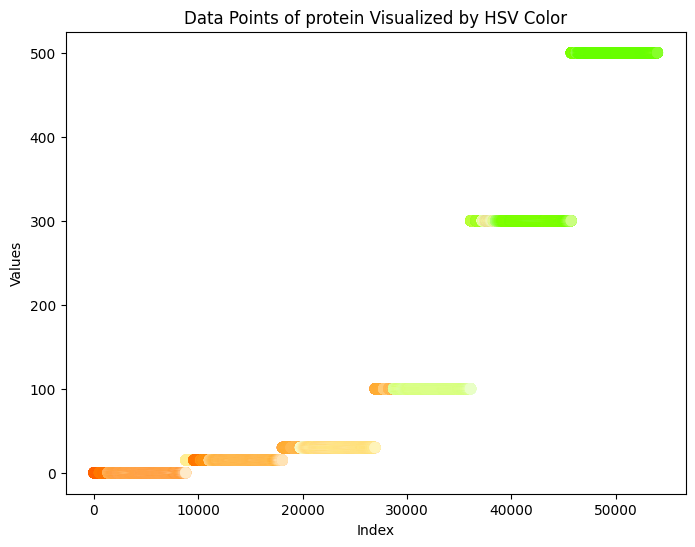

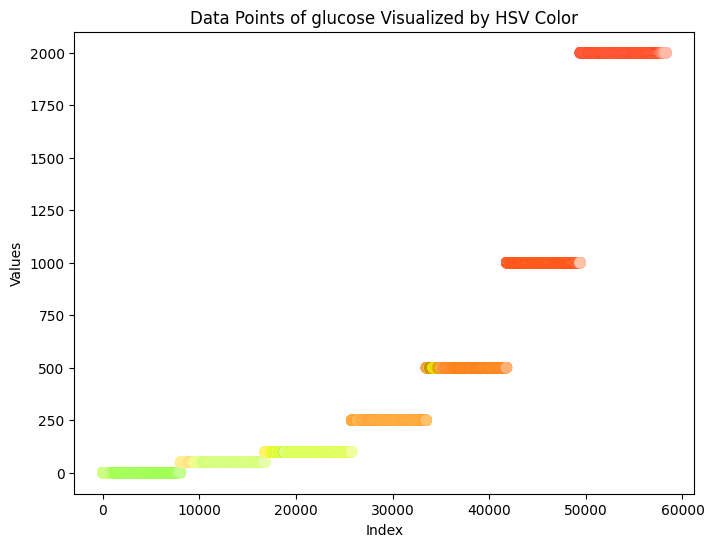

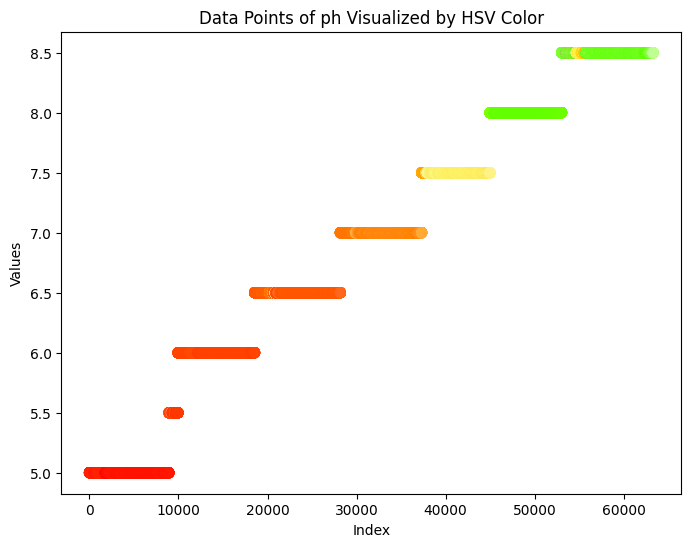

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import colorsys
import numpy as np

datasets = ['protein.csv','glucose.csv','ph.csv']


for item in datasets:
  # Load the data
  data = pd.read_csv(item)

  # Convert 'h', 's', 'v' columns to numeric, forcing non-numeric to NaN
  data['h'] = pd.to_numeric(data['h'], errors='coerce')
  data['s'] = pd.to_numeric(data['s'], errors='coerce')
  data['v'] = pd.to_numeric(data['v'], errors='coerce')

  # Drop rows with NaN values in 'h', 's', or 'v' columns
  data = data.dropna(subset=['h', 's', 'v'])

  # Normalize HSV values to 0-1 range, clipping values outside the range
  data['h'] = np.clip(data['h'] / 360.0, 0, 1)  # Hue is often in 0-360 range
  data['s'] = np.clip(data['s'] / 100.0, 0, 1)  # Saturation is often in 0-100 range if expressed as percentage
  data['v'] = np.clip(data['v'] / 100.0, 0, 1)   # Value is often in 0-100 range if expressed as percentage


  # Convert HSV values to RGB for matplotlib
  rgb_colors = [colorsys.hsv_to_rgb(h, s, v) for h, s, v in zip(data['h'], data['s'], data['v'])]

  # Create the scatter plot
  plt.figure(figsize=(8, 6))
  plt.scatter(data.index, data['value'], c=rgb_colors, marker='o', s=50)  # Changed 'values' to 'value'

  # Set plot labels and title
  plt.xlabel("Index")
  plt.ylabel("Values")  # You can adjust the y-axis label if needed
  plt.title(f"Data Points of {item[:-4]} Visualized by HSV Color")

  # Show the plot
  plt.show()

# Train and Test


Training KNN models for glucose

k=3
R² Score: 0.9994
MAE: 0.5644
MSE: 306.5914
RMSE: 17.5098

k=5
R² Score: 0.9992
MAE: 0.6412
MSE: 400.9944
RMSE: 20.0248

k=10
R² Score: 0.9992
MAE: 0.7617
MSE: 405.4629
RMSE: 20.1361


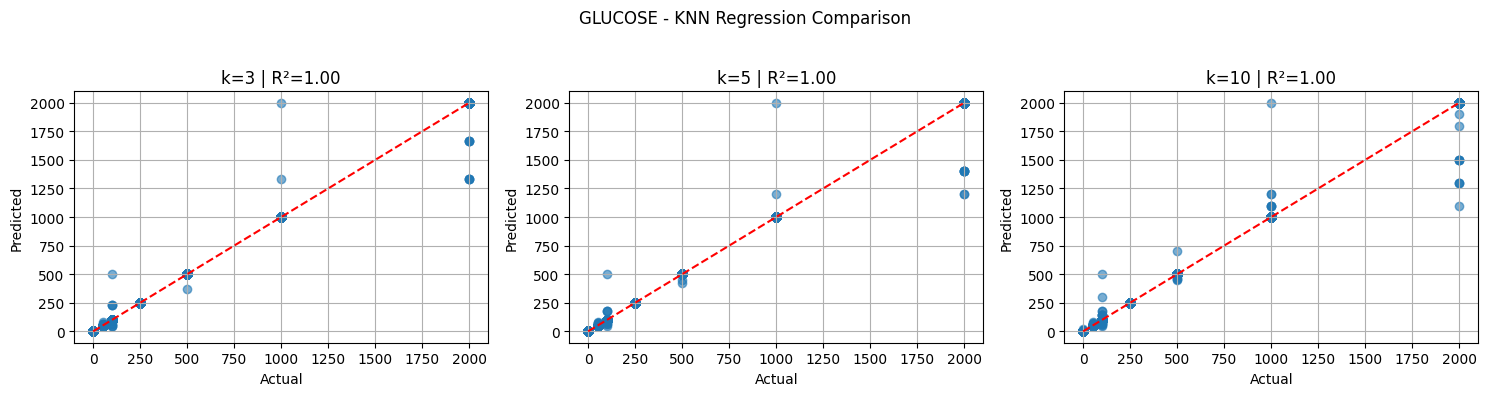


✔ Best model for glucose: k=3 with R²=0.9994

Training KNN models for protein

k=3
R² Score: 0.9923
MAE: 2.5749
MSE: 249.7253
RMSE: 15.8027

k=5
R² Score: 0.9925
MAE: 2.6968
MSE: 241.6528
RMSE: 15.5452

k=10
R² Score: 0.9926
MAE: 2.9658
MSE: 240.1656
RMSE: 15.4973


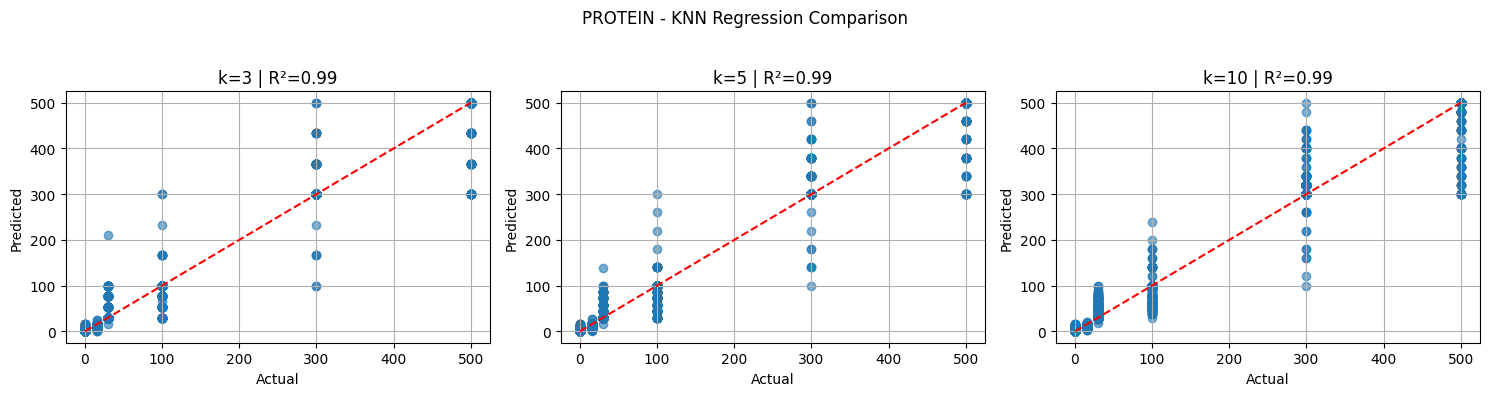


✔ Best model for protein: k=10 with R²=0.9926

Training KNN models for ph

k=3
R² Score: 0.9976
MAE: 0.0040
MSE: 0.0031
RMSE: 0.0556

k=5
R² Score: 0.9979
MAE: 0.0041
MSE: 0.0027
RMSE: 0.0522

k=10
R² Score: 0.9976
MAE: 0.0051
MSE: 0.0031
RMSE: 0.0561


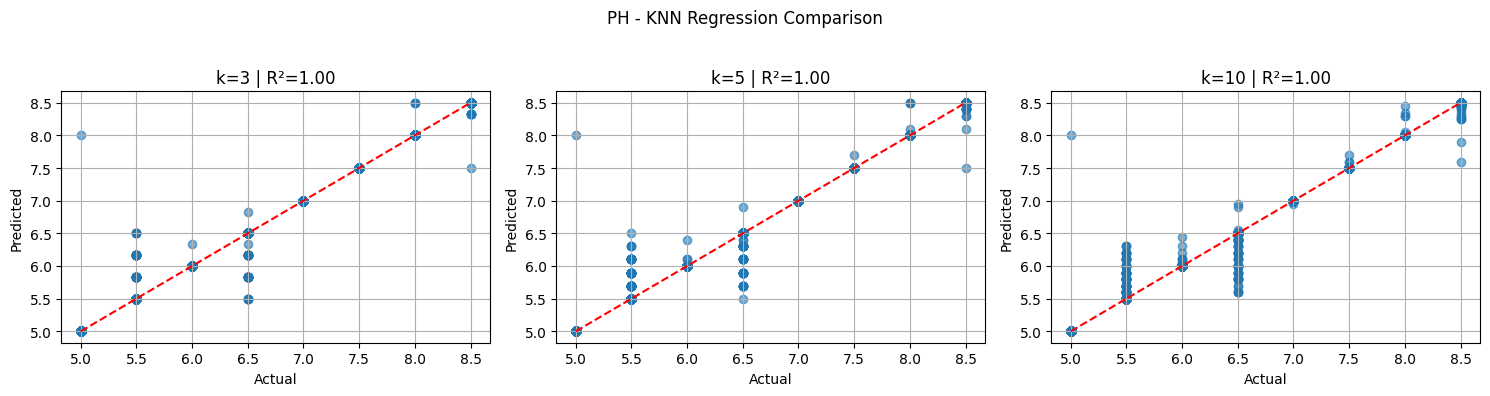


✔ Best model for ph: k=5 with R²=0.9979


In [6]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

def train_and_select_knn(biomarker_name, filename):
    print(f"\nTraining KNN models for {biomarker_name}")

    # Load data
    data = pd.read_csv(filename)
    X = data[["h", "s", "v"]]
    y = data["value"]

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    best_score = -float('inf')
    best_model = None
    best_k = None

    plt.figure(figsize=(15, 4))

    for idx, k in enumerate([3, 5, 10]):
        model = KNeighborsRegressor(n_neighbors=k)
        model.fit(X_train, y_train)
        preds = model.predict(X_test)

        r2 = r2_score(y_test, preds)
        mae = mean_absolute_error(y_test, preds)
        mse = mean_squared_error(y_test, preds)
        rmse = np.sqrt(mse)

        print(f"\nk={k}")
        print(f"R² Score: {r2:.4f}")
        print(f"MAE: {mae:.4f}")
        print(f"MSE: {mse:.4f}")
        print(f"RMSE: {rmse:.4f}")

        # Save each model
        with open(f"{biomarker_name}_model_{k}.pkl", "wb") as file:
            pickle.dump(model, file)

        # Plot actual vs predicted
        plt.subplot(1, 3, idx + 1)
        plt.scatter(y_test, preds, alpha=0.6)
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
        plt.title(f"k={k} | R²={r2:.2f}")
        plt.xlabel("Actual")
        plt.ylabel("Predicted")
        plt.grid(True)

        if r2 > best_score:
            best_score = r2
            best_model = model
            best_k = k

    plt.suptitle(f"{biomarker_name.upper()} - KNN Regression Comparison")
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    # Save best model
    with open(f"{biomarker_name}_model.pkl", "wb") as file:
        pickle.dump(best_model, file)

    print(f"\n✔ Best model for {biomarker_name}: k={best_k} with R²={best_score:.4f}")

# Run for each biomarker
train_and_select_knn("glucose", "glucose.csv")
train_and_select_knn("protein", "protein.csv")
train_and_select_knn("ph", "ph.csv")
